# File Description

This notebook contains the most up-to-date version of the pilot model for total water level on Tarawa, currently for only two locations (one lagoon side and one ocean side).

Currently needs work:
- Incorporating MEI into network
- Adjusting the binning of the MSL distributions to account for future SLR
- Adding SLR projections as evidence option

<cite data-cite="2344856/I2LE4LVY"></cite>


<div class="cite2c-biblio"></div>

# File Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import itertools
import os
import json
from datetime import datetime
import pysmile
import pysmile_license
import sys
import json
sys.path.append('/src/python_classes')
import rpy2
# os.environ['R_HOME'] = 'C:\ProgramData\Anaconda3\Lib\R'
# %load_ext rpy2.ipython
!jupyter nbextension enable --py --sys-prefix ipyleaflet
from ipywidgets import interact, interactive, fixed, interact_manual
from ipyleaflet import *
import ipywidgets as widgets
from matplotlib.animation import FuncAnimation
import geojson
import folium
from colormap import rgb2hex
import rpy2
os.environ['R_HOME'] = '/lib/R'
%load_ext rpy2.ipython
from folium.plugins import FloatImage

from BNModel import BNModel

from preprocessing_all_points import *
from preprocessing_points_spatially import *

Enabling notebook extension jupyter-leaflet/extension...
      - Validating: OK


In [3]:
# ### set location of file storage
# folder = 'BN_antonio_data'
# try:
#     os.makedirs(folder)
# except FileExistsError:
#     pass

# Data Prep

## Preprocessing

In [4]:
# Import and preprocess data
df_ocean,df_lagoon = preprocessing_points_spatially()
df_lagoon,lagoon_data_dict = BN_Antonio_preprocessing_lagoon(df_lagoon)
df_ocean,ocean_data_dict = BN_Antonio_preprocessing_ocean(df_ocean)

## Create Variable Dictionary

In [5]:
#### Don't include spaces in bin names. if no discretisation, just leave out that key
lagoon_model_dict = {
    'variables':{
        'wind_u':{
            'label':'Wind u vector',
            'discretisation':{
                'n_bins':5,
                'strategy':'kmeans',
                'bin_names':['VeryLow','Low','Mid','High','VeryHigh']
            },
            'child_nodes':['TWL_less_Tide']
        },
        'wind_v':{
            'label':r'Wind v vector',
            'discretisation':{
                'n_bins':5,
                'strategy':'uniform',
                'bin_names':['VeryLow','Low','Mid','High','VeryHigh']
            },
            'child_nodes':['TWL_less_Tide']
        },
        'Hs_offshore':{
            'label':'Offshore wave height',
            'discretisation':{
                'n_bins':5,
                'strategy':'kmeans',
                'bin_names':['VeryLow','Low','Mid','HighMid','VeryHigh']
            },
            'child_nodes':['TWL_less_Tide']
        },
        'Tm_offshore':{
            'label':'Offshore wave period',
            'discretisation':{
                'n_bins':5,
                'strategy':'kmeans',
                'bin_names':['VeryLow','Low','Mid','High','VeryHigh']
            },
            'child_nodes':['TWL_less_Tide']
        },
        'Dir_offshore':{
            'label':r'Offshore wave direction',
            'discretisation':{
                'n_bins':8,
                'strategy':'kmeans',
                'bin_names':['NNE','ENE','ESE','SSE','SSW','WSW','WNW','NNW']
            },
            'child_nodes':['TWL_less_Tide']
        },
        'TWL':{
            'label':'Total water level',
            'discretisation':{
                'n_bins':7,
                'strategy':'binned',
                'bin_names':['VeryLow','Low','LowMid','Mid','MidHigh','High','VeryHigh'],
                'bin_edges':np.arange(-1,3.0,0.5)
            },
            'child_nodes':[]
        },
        'TWL_less_Tide':{
            'label':'Total water level less tide',
            'discretisation':{
                'n_bins':5,
                'strategy':'kmeans',
                'bin_names':['VeryLow','Low','Mid','High','VeryHigh']
            },
            'child_nodes':['TWL']
        },
        'MSL':{
            'label':'Mean sea level',
            'discretisation':{
                'n_bins':5,
                'strategy':'kmeans',
                'bin_names':['VeryLow','Low','Mid','High','VeryHigh']
            },
            'child_nodes':['TWL_less_Tide']
        },
        'Tide':{
            'label':'Tide',
            'discretisation':{
                'n_bins':5,
                'strategy':'kmeans',
                'bin_names':['VeryLow','Low','Mid','High','VeryHigh']
            },
            'child_nodes':['TWL']
        }
    },
    'training_frac':0.8,
    'bootstrap_reps':1
}

In [6]:
ocean_model_dict = {
   'variables':{
       'Tm_offshore':{
            'label':'Wave period offshore',
            'discretisation':{
                'n_bins':5,
                'strategy':'kmeans',
                'bin_names':['VeryLow','Low','Mid','High','VeryHigh']
            },
            'child_nodes':['TWL_less_Tide']
        },
        'Hs_offshore':{
            'label':'Wave height offshore',
            'discretisation':{
                'n_bins':5,
                'strategy':'kmeans',
                'bin_names':['VeryLow','Low','Mid','High','VeryHigh']
            },
            'child_nodes':['TWL_less_Tide']
        },
        'Dir_offshore':{
            'label':'Wave direction offshore',
            'discretisation':{
                'n_bins':8,
                'strategy':'kmeans',
                'bin_names':['NNE','ENE','ESE','SSE','SSW','WSW','WNW','NNW']
            },
            'child_nodes':['TWL_less_Tide']
        },
        'MSL':{
            'label':'Mean sea level',
            'discretisation':{
                'n_bins':5,
                'strategy':'kmeans',
                'bin_names':['VeryLow','Low','Mid','High','VeryHigh']
            },
            'child_nodes':['TWL_less_Tide']
        },
        'Tide':{
            'label':'Tide',
            'discretisation':{
                'n_bins':5,
                'strategy':'kmeans',
                'bin_names':['VeryLow','Low','Mid','High','VeryHigh']
            },
            'child_nodes':['TWL']
        },
        'TWL':{
            'label':'Total water level',
            'discretisation':{
                'n_bins':7,
                'strategy':'binned',
                'bin_names':['VeryLow','Low','LowMid','Mid','MidHigh','High','VeryHigh'],
                'bin_edges':np.arange(-1,3.0,0.5)
            },
            'child_nodes':[]
        },
        'TWL_less_Tide':{
            'label':'Total water level less tide',
            'discretisation':{
                'n_bins':5,
                'strategy':'kmeans',
                'bin_names':['VeryLow','Low','Mid','High','VeryHigh']
            },
            'child_nodes':['TWL']
        },
        'reef_width':{
            'label':'Reef width',
            'discretisation':{
                'n_bins':5,
                'strategy':'kmeans',
                'bin_names':['VeryLow','Low','Mid','High','VeryHigh']
            },
            'child_nodes':['TWL_less_Tide']
        },
        'reef_depth':{
            'label':'Reef depth',
            'discretisation':{
                'n_bins':5,
                'strategy':'kmeans',
                'bin_names':['VeryLow','Low','Mid','High','VeryHigh']
            },
            'child_nodes':['TWL_less_Tide']
        },
        'forereef_slope':{
            'label':'Fore reef slope',
            'discretisation':{
                'n_bins':5,
                'strategy':'kmeans',
                'bin_names':['VeryLow','Low','Mid','High','VeryHigh']
            },
            'child_nodes':['TWL_less_Tide']
        },
        'shore_dir':{
            'label':'Shoreline direction',
            'discretisation':{
                'n_bins':3,
                'strategy':'kmeans',
                'bin_names':['NE','S','NW']
            },
            'child_nodes':['TWL_less_Tide']
        } 
   },
    'training_frac':0.8,
    'bootstrap_reps':1
}

## Bootstrapping the data

In [7]:
# Bootstrap the data, and add it to the model_dict
lagoon_model_dict = BNModel().bootstrap_data(lagoon_model_dict,lagoon_data_dict,df_lagoon)

ocean_model_dict = BNModel().bootstrap_data(ocean_model_dict,ocean_data_dict,df_ocean)

## Discretise the data

In [8]:
# Discretise the data
lagoon_file_label = "lagoon"
ocean_file_label = "ocean"

lagoon_model_dict = BNModel().discretiser(lagoon_model_dict)
ocean_model_dict = BNModel().discretiser(ocean_model_dict)

In [9]:
# lagoon_model_dict['variables']['MEI']

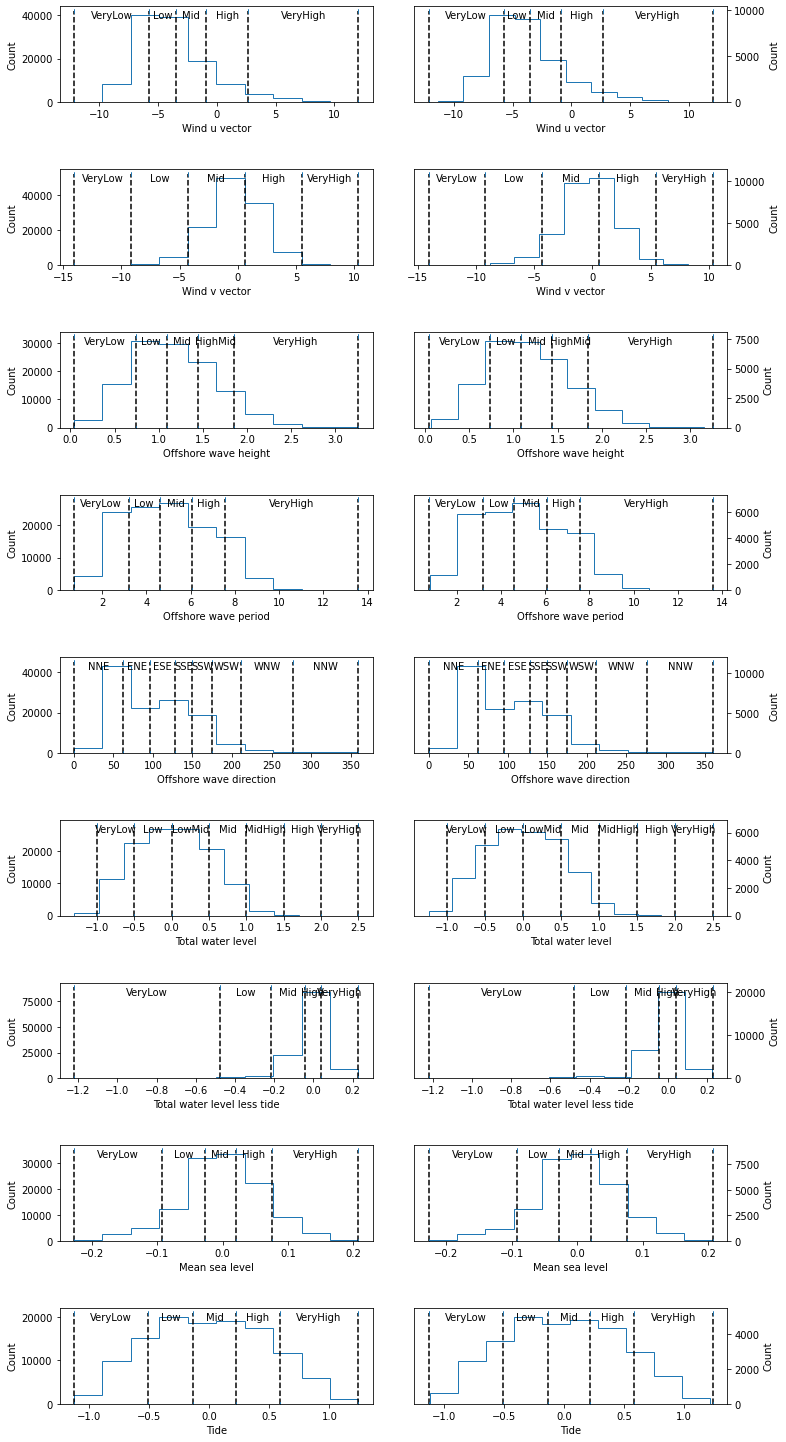

In [10]:
lagoon_disc_fig = BNModel().plot_discretiser(lagoon_model_dict)

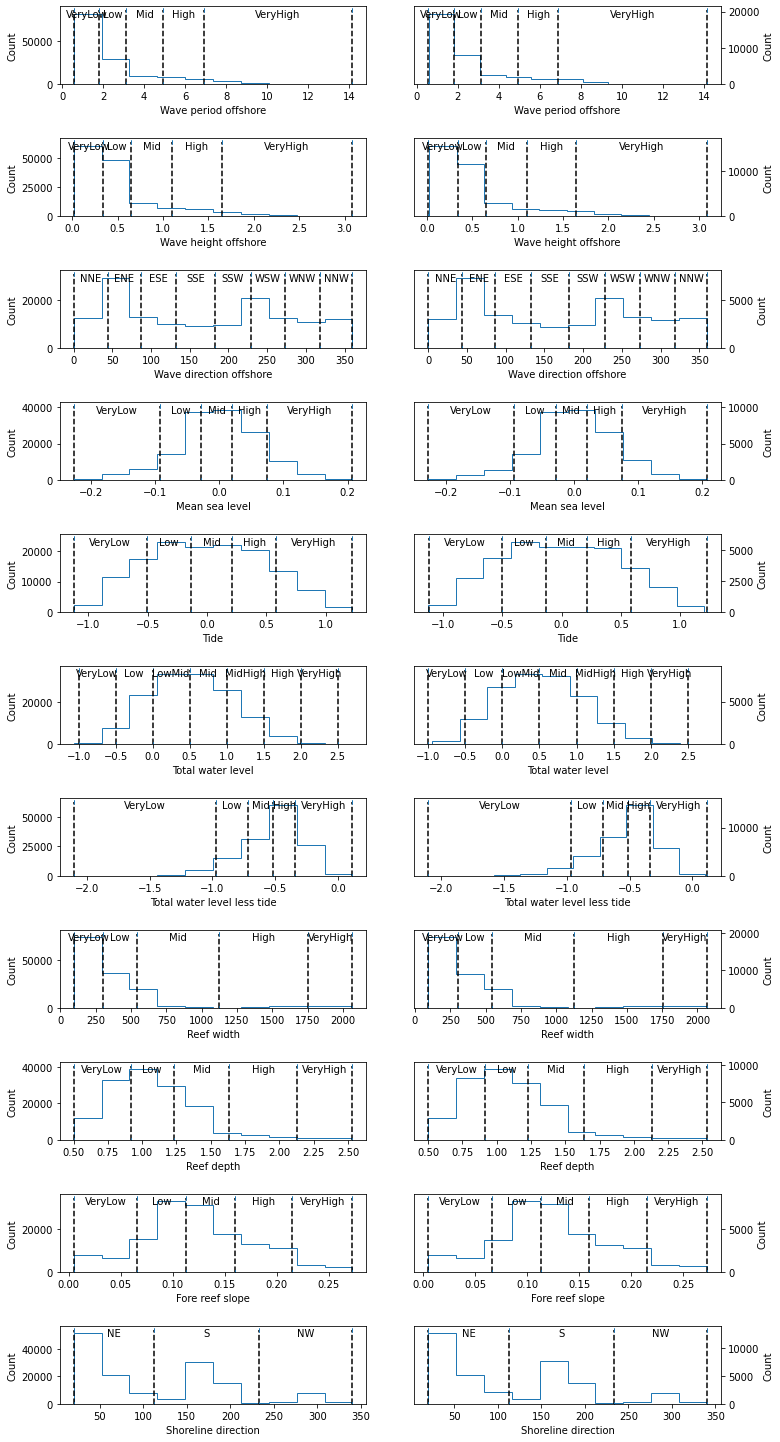

In [11]:
ocean_disc_fig = BNModel().plot_discretiser(ocean_model_dict)

## Save the data

In [12]:
BNModel().save_dataset(lagoon_model_dict,lagoon_file_label)
BNModel().save_dataset(ocean_model_dict,ocean_file_label)

# Create BN Model

In [13]:
# Create the BN
lagoon_model_dict = BNModel().create_SM(lagoon_model_dict,lagoon_file_label)

In [14]:
ocean_model_dict = BNModel().create_SM(ocean_model_dict,ocean_file_label)

## View Conditional Probability tables

In [15]:
# Get conditional probs tables
BNModel().get_conditional_prob_table(lagoon_model_dict,'TWL')

TWL_less_Tide   VeryLow                                            Low  \
Tide            VeryLow    Low       Mid      High  VeryHigh   VeryLow   
TWL                                                                      
High           0.000000  0.000  0.000000  0.010101  0.322275  0.000000   
Low            0.721239  0.004  0.000000  0.000000  0.000000  0.844961   
LowMid         0.278761  0.872  0.191057  0.000000  0.000000  0.000000   
Mid            0.000000  0.124  0.780488  0.548822  0.000000  0.000000   
MidHigh        0.000000  0.000  0.028455  0.441077  0.672986  0.000000   
VeryHigh       0.000000  0.000  0.000000  0.000000  0.004739  0.000000   
VeryLow        0.000000  0.000  0.000000  0.000000  0.000000  0.155039   

TWL_less_Tide                                         ...     High            \
Tide                Low      Mid      High  VeryHigh  ...  VeryLow       Low   
TWL                                                   ...                      
High           0.000000  0.00000  0.000000  0.012920  ...  0.00000  0.000000   
Low            0.377727  0.00000  0.000000  0.000000  ...  0.02629  0.972727   
LowMid         0.622273  0.78898  0.035162  0.000000  ...  0.00000  0.000000   
Mid            0.000000  0.21102  0.949367  0.204134  ...  0.00000  0.000000   
MidHigh        0.000000  0.00000  0.015471  0.782946  ...  0.00000  0.000000   
VeryHigh       0.000000  0.00000  0.000000  0.000000  ...  0.00000  0.000000   
VeryLow        0.000000  0.00000  0.000000  0.000000  ...  0.97371  0.027273   

TWL_less_Tide                               VeryHigh                      \
Tide                Mid      High  VeryHigh  VeryLow       Low       Mid   
TWL                                                                        
High           0.000000  0.000000  0.000000      0.0  0.000000  0.000000   
Low            0.361981  0.000000  0.000000      0.0  0.791045  0.593579   
LowMid         0.638019  0.798428  0.000000      0.0  0.000000  0.406421   
Mid            0.000000  0.201572  0.920153      0.0  0.000000  0.000000   
MidHigh        0.000000  0.000000  0.079847      0.0  0.000000  0.000000   
VeryHigh       0.000000  0.000000  0.000000      0.0  0.000000  0.000000   
VeryLow        0.000000  0.000000  0.000000      1.0  0.208955  0.000000   

TWL_less_Tide                      
Tide               High  VeryHigh  
TWL                                
High           0.000000  0.000000  
Low            0.000000  0.000000  
LowMid         0.956359  0.051991  
Mid            0.043641  0.919124  
MidHigh        0.000000  0.028884  
VeryHigh       0.000000  0.000000  
VeryLow        0.000000  0.000000  

[7 rows x 25 columns]

In [16]:
# Get conditional probs tables
df_CPT_MSL = BNModel().get_conditional_prob_table(ocean_model_dict,'TWL')

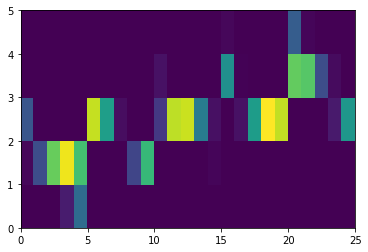

In [17]:
df_CPT_MSL = df_CPT_MSL.loc[['VeryLow','Low','Mid','High','VeryHigh']]

plt.pcolor(df_CPT_MSL)

In [18]:
df_CPT_MSL

Tide            VeryLow                                               Low  \
TWL_less_Tide   VeryLow       Low       Mid      High  VeryHigh   VeryLow   
TWL                                                                         
VeryLow        0.000000  0.000000  0.002930  0.071326  0.334486  0.000000   
Low            0.015279  0.222441  0.731551  0.927834  0.665514  0.000000   
Mid            0.255921  0.000000  0.000000  0.000000  0.000000  0.866945   
High           0.000764  0.000000  0.000000  0.000000  0.000000  0.001193   
VeryHigh       0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

Tide                                                   ...      High  \
TWL_less_Tide       Low       Mid      High  VeryHigh  ...   VeryLow   
TWL                                                    ...             
VeryLow        0.000000  0.000000  0.000000  0.000246  ...  0.000000   
Low            0.000000  0.000000  0.196577  0.639203  ...  0.000000   
Mid            0.528836  0.030431  0.000000  0.000000  ...  0.000000   
High           0.000000  0.000000  0.000000  0.000000  ...  0.470588   
VeryHigh       0.000000  0.000000  0.000000  0.000000  ...  0.015345   

Tide                                                   VeryHigh            \
TWL_less_Tide       Low       Mid      High  VeryHigh   VeryLow       Low   
TWL                                                                         
VeryLow        0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
Low            0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
Mid            0.044029  0.522727  0.951574  0.862997  0.000000  0.000000   
High           0.005192  0.000000  0.000000  0.000000  0.722967  0.700570   
VeryHigh       0.000000  0.000000  0.000000  0.000000  0.277033  0.012251   

Tide                                         
TWL_less_Tide       Mid      High  VeryHigh  
TWL                                          
VeryLow        0.000000  0.000000  0.000000  
Low            0.000000  0.000000  0.000000  
Mid            0.000000  0.066522  0.503206  
High           0.222197  0.027042  0.000279  
VeryHigh       0.000000  0.000000  0.000000  

[5 rows x 25 columns]

# Set Evidence

In [19]:
lagoon_evidence_dict = {
    'wind_u':[0.05,0.1,0.01,0.01,0.01],
    'wind_v':[0.05,0.1,0.01,0.01,0.01,0.01]
}

ocean_evidence_dict = {
    'MSL':[0.05,0.1,0.01,0.01,0.01],
    'Tide':[0.05,0.1,0.01,0.01,0.01,0.01]
}

In [20]:
lagoon_model_dict = BNModel().add_evidence_to_dict(lagoon_model_dict,lagoon_evidence_dict)
ocean_model_dict = BNModel().add_evidence_to_dict(ocean_model_dict,ocean_evidence_dict)

# Update beliefs based on evidence

In [21]:
# Set evidence and get beliefs
lagoon_model_dict = BNModel().update_evidence(lagoon_model_dict)
ocean_model_dict = BNModel().update_evidence(ocean_model_dict)

# BN Visualisation

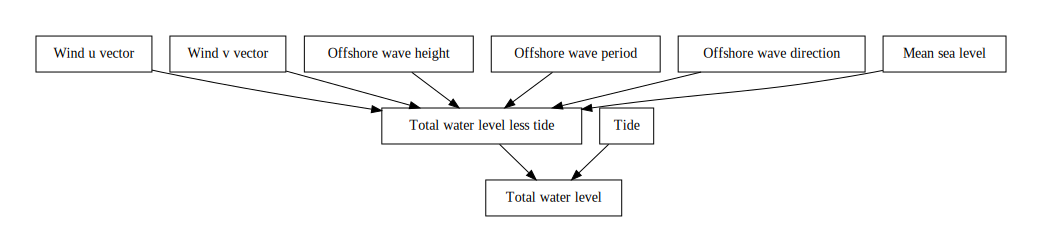

In [22]:

# Set up graph
graph_lagoon = BNModel().create_BN_graph()

# Create nodes of the graph
graph_lagoon,lagoon_model_dict = BNModel().create_nodes(graph_lagoon,lagoon_model_dict,0)

# Create arcs between nodesb
graph_lagoon = BNModel().create_arcs(graph_lagoon,lagoon_model_dict)

# Save as dot file
graph_lagoon.render(filename='graph_lagoon',format='png')

# Plot the graph
graph_lagoon


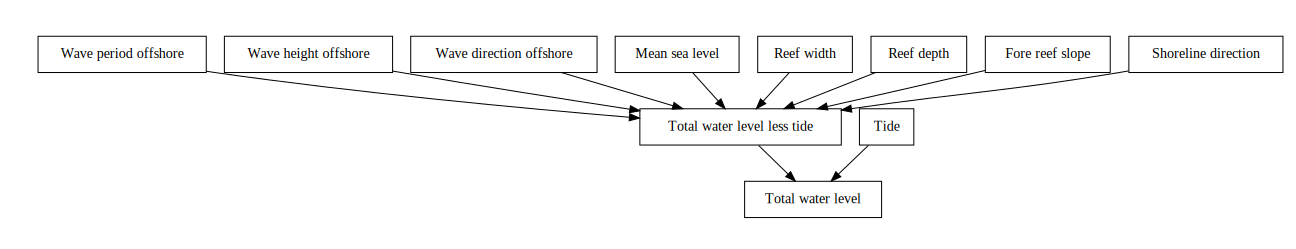

In [23]:

# Set up graph
graph_ocean = BNModel().create_BN_graph()

# Create nodes of the graph
graph_ocean,ocean_model_dict = BNModel().create_nodes(graph_ocean,ocean_model_dict,0)

# Create arcs between nodesb
graph_ocean = BNModel().create_arcs(graph_ocean,ocean_model_dict)

# Save as dot file
graph_ocean.render(filename='graph_ocean',format='png')

# Plot the graph
graph_ocean

# Model Validation

In [24]:
# ### Research picking number of kfolds 

# lagoon_acc_dict = BNModel().get_accuracies(lagoon_model_dict,"TWL")

# print(lagoon_acc_dict)

# fig, ax = BNModel().confusion_matrix(lagoon_model_dict,"TWL",0)

In [25]:

# ocean_acc_dict = BNModel().get_accuracies(ocean_model_dict,"TWL")

# print(ocean_acc_dict)

# fig, ax = BNModel().confusion_matrix(ocean_model_dict,"TWL",0)

# Sensitivity Analysis

## Lagoon

### Tide on TWL

# MSL Priors based on Future Projections

## Get the distribution of MSL data currently

In [26]:
# def grouping_bins(data):
#     grouped_dict = {}

#     for bin_name in np.unique(data):
#         grouped_dict.update({
#             bin_name:len(data[data==bin_name])
#         })
        
#     df_grouped = pd.DataFrame.from_dict(grouped_dict,orient='index')
    
#     return(df_grouped)

In [27]:
# def descretiser(bin_edges,bin_names,data_array):
    
#     discretised_array = np.empty(len(data_array)).astype(str)
    
#     for lower, upper, bin_name in zip(
#         bin_edges[:-1],
#         bin_edges[1:],
#         bin_names):
        
#         discretised_array[(data_array>lower)&(data_array<upper)] = bin_name

#         # Now Include out of bounds values in the upper and lower bins
#         discretised_array[data_array<np.min(bin_edges)] = bin_names[0]
#         discretised_array[data_array>np.max(bin_edges)] = bin_names[-1]
        
#     return(discretised_array)
                    

In [28]:
# # Bin the MSL data
# MSL_data = lagoon_model_dict['variables']['MSL']['training_data'][0]

# # Grouping the bins 
# MSL_bins_grouped = grouping_bins(MSL_data)

# # Put the bins in the right order
# df_MSL_distribution = MSL_bins_grouped.reindex(lagoon_model_dict['variables']['MSL']['discretisation']['bin_names'])

# # Plot the data
# plt.plot(df_MSL_distribution)

## Add the Global average for now

In [29]:
# # Get the preprocessed data to add to
# MSL_training_data_preprocessed = lagoon_model_dict['variables']['MSL']['training_data_preprocessed'][0]
# MSL_testing_data_preprocessed = lagoon_model_dict['variables']['MSL']['testing_data_preprocessed'][0]

# # Print some stats to get an idea of how adding SLR will affect the data
# print(np.min(MSL_training_data_preprocessed))
# print(np.max(MSL_training_data_preprocessed))
# print(np.mean(MSL_training_data_preprocessed))
# print(np.median(MSL_training_data_preprocessed))

In [30]:
# # Based on a 2 mm/yr rate
# mean_SLR_2050 = 2*29/1000
# mean_SLR_2100 = 2*59/1000

# # Get MSLs adjusted for regional sea level rise
# MSL_2050 = MSL_training_data_preprocessed+mean_SLR_2050
# MSL_2100 = MSL_training_data_preprocessed+mean_SLR_2100

In [31]:
# # Using the bins from before, discretise the results
# bin_edges = lagoon_model_dict['variables']['MSL']['bin_edges'][0]
# bin_names = lagoon_model_dict['variables']['MSL']['discretisation']['bin_names']

# # Normalise the data
# df_MSL_2021 = df_MSL_distribution/np.nansum(df_MSL_distribution)

# # Calculated discretised MSL for the scenarios
# MSL_2050 = MSL_training_data_preprocessed+mean_SLR_2050
# MSL_2050_discretised = descretiser(bin_edges,bin_names,MSL_2050)
# df_MSL_2050 = grouping_bins(MSL_2050_discretised)
# df_MSL_2050 = df_MSL_2050.reindex(lagoon_model_dict['variables']['MSL']['discretisation']['bin_names'])
# df_MSL_2050[df_MSL_2050.isna()] = 0.001
# df_MSL_2050 = df_MSL_2050/np.nansum(df_MSL_2050)

# # Calculated discretised MSL for the scenarios
# MSL_2100 = MSL_training_data_preprocessed+mean_SLR_2100
# MSL_2100_discretised = descretiser(bin_edges,bin_names,MSL_2100)
# df_MSL_2100 = grouping_bins(MSL_2100_discretised)
# df_MSL_2100 = df_MSL_2100.reindex(lagoon_model_dict['variables']['MSL']['discretisation']['bin_names'])
# df_MSL_2100[df_MSL_2100.isna()] = 0.001
# df_MSL_2100 = df_MSL_2100/np.nansum(df_MSL_2100)


### Set evidence of 2050

In [32]:
# # Create dict of evidence
# MSL_2050_evidence_dict = {
#     'MSL':list(df_MSL_2050[0])
# }

# # Add evidence for MSL to the model dict
# lagoon_model_dict = BNModel().add_evidence_to_dict(lagoon_model_dict,MSL_2050_evidence_dict)
# ocean_model_dict = BNModel().add_evidence_to_dict(ocean_model_dict,MSL_2050_evidence_dict)

# # Set evidence and get beliefs
# lagoon_model_dict = BNModel().update_evidence(lagoon_model_dict)

# # TWL posterior 2050
# TWL_MSL_2050_posterior_dict = lagoon_model_dict['variables']['TWL_point_110']['resulting_probs'][0]
# df_TWL_MSL_2050_posterior = pd.DataFrame.from_dict(TWL_MSL_2050_posterior_dict,orient='index')

In [33]:
# # Create dict of evidence
# MSL_2100_evidence_dict = {
#     'MSL':list(df_MSL_2100[0])
# }

# # Add evidence for MSL to the model dict
# lagoon_model_dict = BNModel().add_evidence_to_dict(lagoon_model_dict,MSL_2100_evidence_dict)
# ocean_model_dict = BNModel().add_evidence_to_dict(ocean_model_dict,MSL_2100_evidence_dict)

# # Set evidence and get beliefs
# lagoon_model_dict = BNModel().update_evidence(lagoon_model_dict)

# # TWL posterior 2100
# TWL_MSL_2100_posterior_dict = lagoon_model_dict['variables']['TWL_point_110']['resulting_probs'][0]
# df_TWL_MSL_2100_posterior = pd.DataFrame.from_dict(TWL_MSL_2100_posterior_dict,orient='index')

In [34]:
# # get the original data to compare it to
# TWL_training_dict = lagoon_model_dict['variables']['TWL_point_110']['training_data'][0]
# df_TWL_training = grouping_bins(TWL_training_dict)
# df_TWL_training = df_TWL_training.reindex(lagoon_model_dict['variables']['MSL']['discretisation']['bin_names'])
# df_TWL_training[df_TWL_training.isna()] = 0.001
# df_TWL_training = df_TWL_training/np.nansum(df_TWL_training)

# # Create an extra set of dfs for data as a fraction of original
# TWL_MSL_2050 = [(ind,y/x) for ind,x,y in zip(df_TWL_training.index,df_TWL_training[0],df_TWL_MSL_2050_posterior[0])]
# TWL_MSL_2100 = [(ind,y/x) for ind,x,y in zip(df_TWL_training.index,df_TWL_training[0],df_TWL_MSL_2100_posterior[0])]
# df_TWL_MSL_2050 = pd.DataFrame(TWL_MSL_2050).set_index(0)
# df_TWL_MSL_2100 = pd.DataFrame(TWL_MSL_2100).set_index(0)

In [35]:

# # Set up the figure
# fig = plt.figure(figsize=(10,15))
# fig.subplots_adjust(hspace=0.5)
# ax1 = plt.subplot2grid((3,1),(0,0))
# ax2 = plt.subplot2grid((3,1),(1,0))
# ax3 = plt.subplot2grid((3,1),(2,0))

# # Plot MSL data and prior distributions
# ax1.plot(df_MSL_2021,c='k')
# ax1.plot(df_MSL_2050,c='b')
# ax1.plot(df_MSL_2100,c='r')

# # Plot posterior distributions compared to original data
# output_2021, = ax2.plot(df_TWL_training,c='k')
# output_2050, = ax2.plot(df_TWL_MSL_2050_posterior,c='b')
# output_2100, = ax2.plot(df_TWL_MSL_2100_posterior,c='r')

# # Plot posterior distributions as a fraction of the original data
# output_2050, = ax3.plot(df_TWL_MSL_2050,c='b')
# output_2100, = ax3.plot(df_TWL_MSL_2100,c='r')
# ax3_xlims = ax3.get_xlim()
# ax3.plot(ax3_xlims,[1,1],c='0.5',ls='--')
# ax3.set_xlim(ax3_xlims)

# # Format the graph
# ax1.set_ylabel('Probability')
# ax1.set_xlabel('Mean Sea Level')
# ax2.set_ylabel('Probability')
# ax2.set_xlabel('Total Water Level')
# ax3.set_ylabel('Probability/Probability')
# ax3.set_xlabel('Total Water Level')

# ax1.legend([output_2021,output_2050,output_2100],['Present','2050','2100'])


# Load in some IPCC RSL Data

In [36]:
# The IPCC data (Openheimer et al., 2019, IPCC Ch4) is relative to the 1983-2005
# Antonio's data is 1993-2017

# It's not clear to me right now if the IPCC data is relative to the 1983-2005 value globally averaged, 
# or if it varies regionally


In [37]:
# import xarray as xr
# tarawa_lat = 1.333
# tarawa_long = 173

In [38]:
# # Load the RSLD from IPCC, chapter
# ds_RSLR_2040_rcp26 = xr.open_dataset (r'C:\Users\shannonb\Documents\Model_and_data\Dataset\Additional_data\Sea_levels\Data\Chapter4_SM\SM4.2\rsl_26_2040.nc')
# ds_RSLR_2040_rcp45 = xr.open_dataset (r'C:\Users\shannonb\Documents\Model_and_data\Dataset\Additional_data\Sea_levels\Data\Chapter4_SM\SM4.2\rsl_45_2040.nc')
# ds_RSLR_2040_rcp85 = xr.open_dataset (r'C:\Users\shannonb\Documents\Model_and_data\Dataset\Additional_data\Sea_levels\Data\Chapter4_SM\SM4.2\rsl_85_2040.nc')

# ds_RSLR_2055_rcp26 = xr.open_dataset (r'C:\Users\shannonb\Documents\Model_and_data\Dataset\Additional_data\Sea_levels\Data\Chapter4_SM\SM4.2\rsl_26_2055.nc')
# ds_RSLR_2055_rcp45 = xr.open_dataset (r'C:\Users\shannonb\Documents\Model_and_data\Dataset\Additional_data\Sea_levels\Data\Chapter4_SM\SM4.2\rsl_45_2055.nc')
# ds_RSLR_2055_rcp85 = xr.open_dataset (r'C:\Users\shannonb\Documents\Model_and_data\Dataset\Additional_data\Sea_levels\Data\Chapter4_SM\SM4.2\rsl_85_2055.nc')

# ds_RSLR_2090_rcp26 = xr.open_dataset (r'C:\Users\shannonb\Documents\Model_and_data\Dataset\Additional_data\Sea_levels\Data\Chapter4_SM\SM4.2\rsl_26_2090.nc')
# ds_RSLR_2090_rcp45 = xr.open_dataset (r'C:\Users\shannonb\Documents\Model_and_data\Dataset\Additional_data\Sea_levels\Data\Chapter4_SM\SM4.2\rsl_45_2090.nc')
# ds_RSLR_2090_rcp85 = xr.open_dataset (r'C:\Users\shannonb\Documents\Model_and_data\Dataset\Additional_data\Sea_levels\Data\Chapter4_SM\SM4.2\rsl_85_2090.nc')


In [39]:
# # Get the RSLR for Tarawa specifically
# RSLR_2040_rcp26 = float(ds_RSLR_2040_rcp26['slr_md'].sel(x=tarawa_long,y=tarawa_lat,method='nearest'))
# RSLR_2055_rcp26 = float(ds_RSLR_2055_rcp26['slr_md'].sel(x=tarawa_long,y=tarawa_lat,method='nearest'))
# RSLR_2090_rcp26 = float(ds_RSLR_2090_rcp26['slr_md'].sel(x=tarawa_long,y=tarawa_lat,method='nearest'))

# RSLR_2040_rcp45 = float(ds_RSLR_2040_rcp45['slr_md'].sel(x=tarawa_long,y=tarawa_lat,method='nearest'))
# RSLR_2055_rcp45 = float(ds_RSLR_2055_rcp45['slr_md'].sel(x=tarawa_long,y=tarawa_lat,method='nearest'))
# RSLR_2090_rcp45 = float(ds_RSLR_2090_rcp45['slr_md'].sel(x=tarawa_long,y=tarawa_lat,method='nearest'))

# RSLR_2040_rcp85 = float(ds_RSLR_2040_rcp85['slr_md'].sel(x=tarawa_long,y=tarawa_lat,method='nearest'))
# RSLR_2055_rcp85 = float(ds_RSLR_2055_rcp85['slr_md'].sel(x=tarawa_long,y=tarawa_lat,method='nearest'))
# RSLR_2090_rcp85 = float(ds_RSLR_2090_rcp85['slr_md'].sel(x=tarawa_long,y=tarawa_lat,method='nearest'))

# #### These values are relative to PI?? If so, I doubt Antonio's numbers are PI---so this needs to be adjusted for

### Use RCP Scenarios to set evidence

In [40]:
# # Get MSLs adjusted for regional sea level rise
# MSL_2040_rcp26 = MSL_training_data_preprocessed+RSLR_2040_rcp26
# MSL_2055_rcp26 = MSL_training_data_preprocessed+RSLR_2055_rcp26
# MSL_2090_rcp26 = MSL_training_data_preprocessed+RSLR_2090_rcp26

# MSL_2040_rcp45 = MSL_training_data_preprocessed+RSLR_2040_rcp45
# MSL_2055_rcp45 = MSL_training_data_preprocessed+RSLR_2055_rcp45
# MSL_2090_rcp45 = MSL_training_data_preprocessed+RSLR_2090_rcp45

# MSL_2040_rcp85 = MSL_training_data_preprocessed+RSLR_2040_rcp85
# MSL_2055_rcp85 = MSL_training_data_preprocessed+RSLR_2055_rcp85
# MSL_2090_rcp85 = MSL_training_data_preprocessed+RSLR_2090_rcp85

In [41]:
# def test_model(evidence_array,model_dict):

#     # Adjust MSL for difference between antonio data and IPCC data
#     SLR_adjustment = 2*11/1000
#     evidence_array -= SLR_adjustment
    
#     # Dicretise the data
#     MSL_discretised = descretiser(bin_edges,bin_names,evidence_array)
#     df_MSL = grouping_bins(MSL_discretised)
#     df_MSL = df_MSL.reindex(model_dict['variables']['MSL']['discretisation']['bin_names'])
#     df_MSL[df_MSL.isna()] = 0.001
#     df_MSL = df_MSL/np.nansum(df_MSL)
    
#     # Create dict of evidence
#     MSL_evidence_dict = {
#         'MSL':list(df_MSL[0])
#     }

#     # Add evidence for MSL to the model dict
#     model_dict = BNModel().add_evidence_to_dict(model_dict,MSL_evidence_dict)

#     # Set evidence and get beliefs
#     model_dict = BNModel().update_evidence(model_dict)

#     # TWL posterior 2100
#     TWL_MSL_posterior_dict = model_dict['variables']['TWL_point_110']['resulting_probs'][0]
#     df_TWL_posterior = pd.DataFrame.from_dict(TWL_MSL_posterior_dict,orient='index')
    
#     return(df_TWL_posterior,df_MSL)

In [42]:
# IPCC_posteriors_dict = {}
# MSL_prior_dict = {}

# MSL_array_list = [MSL_2040_rcp26,MSL_2055_rcp26,MSL_2090_rcp26,MSL_2040_rcp45,MSL_2055_rcp45,MSL_2090_rcp45,MSL_2040_rcp85,MSL_2055_rcp85,MSL_2090_rcp85]

# for array, label in zip(MSL_array_list,
#                         ['RCP2.6, 2040','RCP2.6, 2055','RCP2.6, 2090','RCP4.5, 2040','RCP4.5, 2055','RCP4.5, 2090','RCP8.5, 2040','RCP8.5, 2055','RCP8.5, 2090']):
    
#     df_TWL_posterior, df_MSL = test_model(array, lagoon_model_dict)
    
#     IPCC_posteriors_dict.update({
#         label:df_TWL_posterior
#     })
    
#     MSL_prior_dict.update({
#         label:df_MSL
#     })

In [43]:

# # Set up the figure
# fig = plt.figure(figsize=(10,15))
# fig.subplots_adjust(hspace=0.5)
# ax1 = plt.subplot2grid((3,1),(0,0))
# ax2 = plt.subplot2grid((3,1),(1,0))
# ax3 = plt.subplot2grid((3,1),(2,0))

# # # Plot MSL data and prior distributions
# # ax1.plot(df_MSL_2021,c='k')
# # ax1.plot(df_MSL_2050,c='b')
# # ax1.plot(df_MSL_2100,c='r')
# for key,df_prior in MSL_prior_dict.items():
#     ax1.plot(df_prior)

# # # Plot posterior distributions compared to original data
# # output_2021, = ax2.plot(df_TWL_training,c='k')
# # output_2050, = ax2.plot(df_TWL_MSL_2050_posterior,c='b')
# # output_2100, = ax2.plot(df_TWL_MSL_2100_posterior,c='r')
# outputs = []

# for key,posterior_array in IPCC_posteriors_dict.items():
#     output, = ax2.plot(posterior_array)
#     outputs.append(output)

# # # Plot posterior distributions as a fraction of the original data
# # output_2050, = ax3.plot(df_TWL_MSL_2050,c='b')
# # output_2100, = ax3.plot(df_TWL_MSL_2100,c='r')
# # ax3_xlims = ax3.get_xlim()
# # ax3.plot(ax3_xlims,[1,1],c='0.5',ls='--')
# # ax3.set_xlim(ax3_xlims)

# # Format the graph
# ax1.set_ylabel('Probability')
# ax1.set_xlabel('Mean Sea Level')
# ax2.set_ylabel('Probability')
# ax2.set_xlabel('Total Water Level')
# ax3.set_ylabel('Probability/Probability')
# ax3.set_xlabel('Total Water Level')

# ax1.legend(outputs,IPCC_posteriors_dict.keys())


# Interactive Plots

In [44]:
# load in the reef and shoreline profile information
df_ocean_profiles = pd.read_csv('/src/Dataset/D8_tarawa_inundation/Profiles_definition_outer_reef_xyxy_processed.txt')
df_lagoon_profiles = pd.read_csv('/src/Dataset/D8_tarawa_inundation/Profiles_definition_inner_lagoon_xyxy.txt',delim_whitespace=True,header=None)
df_lagoon_profiles.columns = ['reef_long','reef_lat','shore_long','shore_lat','reef_depth']



In [45]:
def bin_locator(value,bin_edges):
    '''
    function used for determining the index of the appropriate bin for a numerical value.
    '''
    i=0
    for edge_1,edge_2 in zip(bin_edges[:-1],bin_edges[1:]):
        if (value>edge_1)&(value<=edge_2):
            loc_bin = i
        else:
            i+=1
            continue

    if value<=bin_edges[0]:
        loc_bin = 0

    if value>=bin_edges[-1]:
        loc_bin = len(bin_edges)-2

    return(loc_bin)

def model_location(model_dict,location_details,evidence_dict,variable_list):
    
    '''
    function for adding the location information for one side model to the evidence dictionary
    '''
    
    for variable in variable_list:

        bin_edges = model_dict['variables'][variable]['bin_edges'][0]
        value = location_details[variable]

        var_bin = bin_locator(value,bin_edges)
        
        evidence_array = [0]*(len(bin_edges)-1)
        evidence_array[var_bin] = 1
        
        evidence_dict.update({
            variable:evidence_array
        })

    # Add evidence to model dict
    model_location_dict = BNModel().add_evidence_to_dict(model_dict,evidence_dict)
    
    # Set evidence and get beliefs
    model_location_dict = BNModel().update_evidence(model_location_dict)
    
    return(model_location_dict)

def location_probabilities(evidence_dict,model_dict,variable_list,df_profiles):
    '''
    
    Function for setting evidence and determing probabilties for twl at each point around the island based 
    on the reef characteristics at each location
    
    '''
    
    location_probabilities_dict = {}
    
    for index,row in df_profiles.iterrows():

        model_location_dict = model_location(model_dict,row,evidence_dict,variable_list)
        location_probabilities = model_location_dict['variables']['TWL']['resulting_probs'][0]

        df_location_probabilities = pd.DataFrame.from_dict(location_probabilities,orient='index')
        
        largest_cat = df_location_probabilities.idxmax()[0]

        location_probabilities_dict.update({
            (row.reef_long,row.reef_lat):\
                model_dict['variables']['TWL']['discretisation']['bin_names'].index(largest_cat)
        })
        
    return(location_probabilities_dict)

def data2geojson(df):
    features = []
    insert_features = lambda X: features.append(
            geojson.Feature(geometry=geojson.Point((X["long"],
                                                    X["lat"])),
                            properties=dict(name=X["most_likely_twl"])))
    df.apply(insert_features, axis=1)
        
    return(geojson.FeatureCollection(features))

# Load SLR Projections
data_location = "/src/Dataset/D7_MSL_projections/"
file_name = "distributions_dict"
with open("{}{}.json".format(data_location,file_name), 'r') as fp:
    SL_proj_dict = json.load(fp)
    
def SLR_proj_extractor(SL_proj_dict,AIS_config,rcp,year):
    '''
    Function for getting SLR projections for a given Antarctic icesheet, rcp and year
    Years start as 2020 and go up in lots of 10 until 2150 (2100 for dp16)
    '''
    SLR_prob_dict = SL_proj_dict["('{}', '{}', {})".format(AIS_config,rcp,year)]
    SLR_median_prob = np.max([float(x) for x in list(SLR_prob_dict.keys())])
    SLR_median_MSL = float(SLR_prob_dict[str(SLR_median_prob)])/1000 #units is m

    return(SLR_median_MSL)

In [46]:
def test_figure(
    view,tide_bin,wave_height_bin,wave_period_bin,wave_direction_bin,wind_u_bin,wind_v_bin,proj_time
    ):
    
    ########### get the MSL bin based on slider value
    msl_proj = SLR_proj_extractor(SL_proj_dict,'k14','26','{}'.format(proj_time))
    ocean_model_dict['variables']['MSL']['bin_edges'][0]
    bin_count = bin_locator(msl_proj,ocean_model_dict['variables']['MSL']['bin_edges'][0])
    msl_bin = ocean_model_dict['variables']['MSL']['discretisation']['bin_names'][bin_count]
    
    if view == 'Map':
        map_osm = folium.Map(location=[1.448888, 172.991794],zoom_start=11)
    elif view == 'Satellite':
        token = "pk.eyJ1Ijoic2hhbm5vbi1iZW5ndHNvbiIsImEiOiJja3F1Y2Q0dHEwMzYwMm9wYmtzYzk2bDZuIn0.5jGMyEiJdmXs1HL7x3ThPw" # your mapbox token
        tileurl = 'https://api.mapbox.com/v4/mapbox.satellite/{z}/{x}/{y}@2x.png?access_token=' + str(token)

        map_osm = folium.Map(location=[1.448888, 172.991794], zoom_start=11, tiles=tileurl, attr='Mapbox')
        
    twl_bin_edges = [round(x,2) for x in ocean_model_dict['variables']['TWL']['bin_edges'][0]]
    twl_bins = ocean_model_dict['variables']['TWL']['discretisation']['bin_names']

    colours_rgb = matplotlib.pyplot.get_cmap('seismic')(np.arange(0,1+1/len(twl_bins),1/(len(twl_bins)-1)))
    colour_hex_dict = {i:rgb2hex(int(255*colours_rgb[i][0]),int(255*colours_rgb[i][1]),int(255*(colours_rgb[i][2]))) for i in np.arange(0,len(twl_bins),1)}
    
    ################################################
    
    # Create an empty dictionary for the evidence and populate as you go
    ocean_evidence_dict = {}
    
    for var_bin,var_name in zip([tide_bin,msl_bin,wave_height_bin,wave_period_bin,wave_direction_bin],
                                ['Tide','MSL','Hs_offshore','Tm_offshore','Dir_offshore']):

        ## Set in the evidence dict to be as indicated in the dropdown
        bin_index = ocean_model_dict['variables'][var_name]['discretisation']['bin_names'].index(var_bin)
        # Create a list of the tide evidence (all zero except as indicated by dropdown. Dropdown=1)
        evidence = [0 for x in ocean_model_dict['variables'][var_name]['discretisation']['bin_names']]
        evidence[bin_index] = 1
        ocean_evidence_dict.update({
            var_name:evidence
        })
    
    # Create a list of variables that are location specific to set as evidence in the network
    variable_list = ['reef_width','reef_depth','forereef_slope','shore_dir']
    
    # get the probability dictionary
    location_probabilities_dict = location_probabilities(ocean_evidence_dict,ocean_model_dict,variable_list,df_ocean_profiles)
    
    # Create dataframe to plot
    df_twl_locations = pd.DataFrame.from_dict(location_probabilities_dict,orient='index').rename(columns={0:'most_likely_twl'})
    df_twl_locations['long'] = [long for long,lat in df_twl_locations.index]
    df_twl_locations['lat'] = [lat for long,lat in df_twl_locations.index]
    df_twl_locations.reset_index(drop=True,inplace=True)
    
    data_ocean = data2geojson(df_twl_locations)
    
    colors_hex_points_ocean = [colour_hex_dict[x] for x in df_twl_locations.most_likely_twl]
    
    #####################################################################
    
    # Create an empty dictionary for the evidence and populate as you go
    lagoon_evidence_dict = {}
    
    for var_bin,var_name in zip([tide_bin,msl_bin,wave_height_bin,wave_period_bin,wave_direction_bin,wind_u_bin,wind_v_bin],
                                ['Tide','MSL','Hs_offshore','Tm_offshore','Dir_offshore','wind_u','wind_v']):

        ## Set in the evidence dict to be as indicated in the dropdown
        bin_index = lagoon_model_dict['variables'][var_name]['discretisation']['bin_names'].index(var_bin)
        # Create a list of the tide evidence (all zero except as indicated by dropdown. Dropdown=1)
        evidence = [0 for x in lagoon_model_dict['variables'][var_name]['discretisation']['bin_names']]
        evidence[bin_index] = 1
        lagoon_evidence_dict.update({
            var_name:evidence
        })
    
    # Create a list of variables that are location specific to set as evidence in the network
    variable_list = []
    
    # get the probability dictionary
    location_probabilities_dict = location_probabilities(lagoon_evidence_dict,lagoon_model_dict,variable_list,df_lagoon_profiles)
    
    # Create dataframe to plot
    df_twl_locations = pd.DataFrame.from_dict(location_probabilities_dict,orient='index').rename(columns={0:'most_likely_twl'})
    df_twl_locations['long'] = [long for long,lat in df_twl_locations.index]
    df_twl_locations['lat'] = [lat for long,lat in df_twl_locations.index]
    df_twl_locations.reset_index(drop=True,inplace=True)
    
    data_lagoon = data2geojson(df_twl_locations)
    
    colors_hex_points_lagoon = [colour_hex_dict[x] for x in df_twl_locations.most_likely_twl]
    
    #####################################################################
    
    features_list = data_ocean['features']+data_lagoon['features']
    
    data = data_ocean
    data.update({
        'features':features_list
    })
    
    colors_hex_points = colors_hex_points_ocean+colors_hex_points_lagoon
    
    #####################################################################

    for feature,color in zip(features_list,colors_hex_points):
        feature['properties'] = {'color':color,'weight':1,'markerColor':color,'fillOpacity':1,'fillColor':color}
        long,lat = feature['geometry']['coordinates']
        
        marker = folium.CircleMarker([lat,long],color=color,
                                    # popup='<img src={}_{}.png>'.format(int(long*1000),int(lat*1000)),
                                   fill_color=color,fill=True,fill_opacity='1',radius=5)
        marker.add_to(map_osm)
        
    twl_bin_edge_labels = ['{} to {} m'.format(
        x,y) for x,y in zip(twl_bin_edges[:-1],twl_bin_edges[1:])]
        
    output_list = []
    for rgb_color in colours_rgb:
        output = plt.scatter([],[],color=rgb_color)
        output_list.append(output)
        
    legend = plt.legend(output_list,twl_bin_edge_labels,title='Total water level anomaly',fontsize=10)
    plt.setp(legend.get_title(),fontsize=12)
    
    plt.axis('off')
    plt.savefig('legend.png')
    
    plt.close()
    
    url = (
        "legend.png"
    )    
    
    FloatImage(url, bottom=55, left=55).add_to(map_osm)
    
    map_osm.save('test.html')
        
    return(map_osm)
    

# compile the figure
# lagoon_model_dict,ocean_model_dict = initialise_model_dictionaries()
tide_bins = ocean_model_dict['variables']['Tide']['discretisation']['bin_names']
wave_height_bins = ocean_model_dict['variables']['Hs_offshore']['discretisation']['bin_names']
wave_period_bin = ocean_model_dict['variables']['Tm_offshore']['discretisation']['bin_names']
wave_direction_bin = ocean_model_dict['variables']['Dir_offshore']['discretisation']['bin_names']
wind_u_bin = lagoon_model_dict['variables']['wind_u']['discretisation']['bin_names']
wind_v_bin = lagoon_model_dict['variables']['wind_u']['discretisation']['bin_names']
# time = list(model_dicts_through_time_dict.keys())  


# Create the plot with the widget
map_osm = interact(test_figure,
                view = widgets.Dropdown(options=['Map','Satellite'],value='Map',description='View type',disabled=False),
                tide_bin = widgets.Dropdown(options=tide_bins,value='Mid',description='Tide',disabled=False),
                wave_height_bin = widgets.Dropdown(options=wave_height_bins,value='Mid',description='Wave height',disabled=False),
                wave_period_bin = widgets.Dropdown(options=wave_period_bin,value='Mid',description='Wave period',disabled=False),
                wave_direction_bin = widgets.Dropdown(options=wave_direction_bin,value='NNE',description='Wave direction',disabled=False),
                wind_u_bin = widgets.Dropdown(options=wind_u_bin,value='Mid',description='Wind u',disabled=False),
                wind_v_bin = widgets.Dropdown(options=wind_v_bin,value='Mid',description='Wind v',disabled=False),
                proj_time = widgets.IntSlider(min=2020,max=2150,step=10,value=2020,description='SLR prediction')
               )




interactive(children=(Dropdown(description='View type', options=('Map', 'Satellite'), value='Map'), Dropdown(d…

# Save Model

In [47]:
import pickle

ocean_model_save_dict = ocean_model_dict.copy()
lagoon_model_save_dict = lagoon_model_dict.copy()

ocean_model_save_dict.pop('model')
lagoon_model_save_dict.pop('model')

a_file = open("ocean_model.pkl", "wb")
pickle.dump(ocean_model_save_dict, a_file)
a_file.close()

a_file = open("lagoon_model.pkl", "wb")
pickle.dump(lagoon_model_save_dict, a_file)
a_file.close()

# Testing Code

In [48]:
# def test_figure(
#     view,tide_bin,wave_height_bin,wave_period_bin,wave_direction_bin,wind_u_bin,wind_v_bin,proj_time
#     ):
    
#     ########### get the MSL bin based on slider value
#     msl_proj = SLR_proj_extractor(SL_proj_dict,'k14','26','{}'.format(proj_time))
#     ocean_model_dict['variables']['MSL']['bin_edges'][0]
#     bin_count = bin_locator(msl_proj,ocean_model_dict['variables']['MSL']['bin_edges'][0])
#     msl_bin = ocean_model_dict['variables']['MSL']['discretisation']['bin_names'][bin_count]
    
#     if view == 'Map':
#         map_osm = folium.Map(location=[1.448888, 172.991794],zoom_start=11)
#     elif view == 'Satellite':
#         token = "pk.eyJ1Ijoic2hhbm5vbi1iZW5ndHNvbiIsImEiOiJja3F1Y2Q0dHEwMzYwMm9wYmtzYzk2bDZuIn0.5jGMyEiJdmXs1HL7x3ThPw" # your mapbox token
#         tileurl = 'https://api.mapbox.com/v4/mapbox.satellite/{z}/{x}/{y}@2x.png?access_token=' + str(token)

#         map_osm = folium.Map(location=[1.448888, 172.991794], zoom_start=11, tiles=tileurl, attr='Mapbox')
        
#     twl_bin_edges = [round(x,2) for x in ocean_model_dict['variables']['TWL']['bin_edges'][0]]
#     twl_bins = ocean_model_dict['variables']['TWL']['discretisation']['bin_names']

#     colours_rgb = matplotlib.pyplot.get_cmap('seismic')(np.arange(0,1+1/len(twl_bins),1/(len(twl_bins)-1)))
#     colour_hex_dict = {i:rgb2hex(int(255*colours_rgb[i][0]),int(255*colours_rgb[i][1]),int(255*(colours_rgb[i][2]))) for i in np.arange(0,len(twl_bins),1)}
    
#     ################################################
    
#     # Create an empty dictionary for the evidence and populate as you go
#     ocean_evidence_dict = {}
    
#     for var_bin,var_name in zip([tide_bin,msl_bin,wave_height_bin,wave_period_bin,wave_direction_bin],
#                                 ['Tide','MSL','Hs_offshore','Tm_offshore','Dir_offshore']):

#         ## Set in the evidence dict to be as indicated in the dropdown
#         bin_index = ocean_model_dict['variables'][var_name]['discretisation']['bin_names'].index(var_bin)
#         # Create a list of the tide evidence (all zero except as indicated by dropdown. Dropdown=1)
#         evidence = [0 for x in ocean_model_dict['variables'][var_name]['discretisation']['bin_names']]
#         evidence[bin_index] = 1
#         ocean_evidence_dict.update({
#             var_name:evidence
#         })
    
#     # Create a list of variables that are location specific to set as evidence in the network
#     variable_list = ['reef_width','reef_depth','forereef_slope','shore_dir']
    
#     # get the probability dictionary
#     location_probabilities_dict = location_probabilities(ocean_evidence_dict,ocean_model_dict,variable_list,df_ocean_profiles)
    
#     # Get the actual probabilities
#     lagoon_twls = [lagoon_model_dict['variables']['TWL']['discretisation']['bin_names'].index(twl)+1\
#          for twl in lagoon_model_dict['variables']['TWL']['testing_data'][0]]
    
#     print(len(lagoon_twls))
#     print(len(location_probabilities_dict.keys()))
    
#     # Create dataframe to plot
#     df_twl_locations =pd.DataFrame({'most_likely_twl':lagoon_twls})
#     df_twl_locations['long'] = [long for long,lat in df_twl_locations.index]
#     df_twl_locations['lat'] = [lat for long,lat in df_twl_locations.index]
#     df_twl_locations.reset_index(drop=True,inplace=True)
    
#     data_ocean = data2geojson(df_twl_locations)
    
#     colors_hex_points_ocean = [colour_hex_dict[x] for x in df_twl_locations.most_likely_twl]
    
#     #####################################################################
    
#     # Create an empty dictionary for the evidence and populate as you go
#     lagoon_evidence_dict = {}
    
#     for var_bin,var_name in zip([tide_bin,msl_bin,wave_height_bin,wave_period_bin,wave_direction_bin,wind_u_bin,wind_v_bin],
#                                 ['Tide','MSL','Hs_offshore','Tm_offshore','Dir_offshore','wind_u','wind_v']):

#         ## Set in the evidence dict to be as indicated in the dropdown
#         bin_index = lagoon_model_dict['variables'][var_name]['discretisation']['bin_names'].index(var_bin)
#         # Create a list of the tide evidence (all zero except as indicated by dropdown. Dropdown=1)
#         evidence = [0 for x in lagoon_model_dict['variables'][var_name]['discretisation']['bin_names']]
#         evidence[bin_index] = 1
#         lagoon_evidence_dict.update({
#             var_name:evidence
#         })
    
#     # Create a list of variables that are location specific to set as evidence in the network
#     variable_list = []
    
#     # get the probability dictionary
#     location_probabilities_dict = location_probabilities(lagoon_evidence_dict,lagoon_model_dict,variable_list,df_lagoon_profiles)
    
#     # Create dataframe to plot
#     df_twl_locations = pd.DataFrame.from_dict(location_probabilities_dict,orient='index').rename(columns={0:'most_likely_twl'})
#     df_twl_locations['long'] = [long for long,lat in df_twl_locations.index]
#     df_twl_locations['lat'] = [lat for long,lat in df_twl_locations.index]
#     df_twl_locations.reset_index(drop=True,inplace=True)
    
#     data_lagoon = data2geojson(df_twl_locations)
    
#     colors_hex_points_lagoon = [colour_hex_dict[x] for x in df_twl_locations.most_likely_twl]
    
#     #####################################################################
    
#     features_list = data_ocean['features']+data_lagoon['features']
    
#     data = data_ocean
#     data.update({
#         'features':features_list
#     })
    
#     colors_hex_points = colors_hex_points_ocean+colors_hex_points_lagoon
    
#     #####################################################################

#     for feature,color in zip(features_list,colors_hex_points):
#         feature['properties'] = {'color':color,'weight':1,'markerColor':color,'fillOpacity':1,'fillColor':color}
#         long,lat = feature['geometry']['coordinates']
        
#         marker = folium.CircleMarker([lat,long],color=color,
#                                     # popup='<img src={}_{}.png>'.format(int(long*1000),int(lat*1000)),
#                                    fill_color=color,fill=True,fill_opacity='1',radius=5)
#         marker.add_to(map_osm)
        
#     twl_bin_edge_labels = ['{} to {} m'.format(
#         x,y) for x,y in zip(twl_bin_edges[:-1],twl_bin_edges[1:])]
        
#     output_list = []
#     for rgb_color in colours_rgb:
#         output = plt.scatter([],[],color=rgb_color)
#         output_list.append(output)
        
#     legend = plt.legend(output_list,twl_bin_edge_labels,title='Total water level anomaly',fontsize=10)
#     plt.setp(legend.get_title(),fontsize=12)
    
#     plt.axis('off')
#     plt.savefig('legend.png')
    
#     plt.close()
    
#     url = (
#         "legend.png"
#     )    
    
#     FloatImage(url, bottom=55, left=55).add_to(map_osm)
    
#     map_osm.save('test.html')
        
#     return(map_osm)
    

# # compile the figure
# # lagoon_model_dict,ocean_model_dict = initialise_model_dictionaries()
# tide_bins = ocean_model_dict['variables']['Tide']['discretisation']['bin_names']
# wave_height_bins = ocean_model_dict['variables']['Hs_offshore']['discretisation']['bin_names']
# wave_period_bin = ocean_model_dict['variables']['Tm_offshore']['discretisation']['bin_names']
# wave_direction_bin = ocean_model_dict['variables']['Dir_offshore']['discretisation']['bin_names']
# wind_u_bin = lagoon_model_dict['variables']['wind_u']['discretisation']['bin_names']
# wind_v_bin = lagoon_model_dict['variables']['wind_u']['discretisation']['bin_names']
# # time = list(model_dicts_through_time_dict.keys())  


# # Create the plot with the widget
# map_osm = interact_manual(test_figure,
#                 view = widgets.Dropdown(options=['Map','Satellite'],value='Map',description='View type',disabled=False),
#                 tide_bin = widgets.Dropdown(options=tide_bins,value='Mid',description='Tide',disabled=False),
#                 wave_height_bin = widgets.Dropdown(options=wave_height_bins,value='Mid',description='Wave height',disabled=False),
#                 wave_period_bin = widgets.Dropdown(options=wave_period_bin,value='Mid',description='Wave period',disabled=False),
#                 wave_direction_bin = widgets.Dropdown(options=wave_direction_bin,value='NNE',description='Wave direction',disabled=False),
#                 wind_u_bin = widgets.Dropdown(options=wind_u_bin,value='Mid',description='Wind u',disabled=False),
#                 wind_v_bin = widgets.Dropdown(options=wind_v_bin,value='Mid',description='Wind v',disabled=False),
#                 proj_time = widgets.IntSlider(min=2020,max=2150,step=10,value=2020,description='SLR prediction')
#                )

# map_osm

In [49]:
lagoon_twls = [lagoon_model_dict['variables']['TWL']['discretisation']['bin_names'].index(twl)+1\
     for twl in lagoon_model_dict['variables']['TWL']['testing_data'][0]]
df = pd.DataFrame({'most_likely_twl':lagoon_twls})
print(len(df))

30183


In [50]:
lagoon_model_dict['variables']['TWL']['testing_data'][0]

array(['LowMid', 'VeryLow', 'LowMid', ..., 'Low', 'LowMid', 'LowMid'],
      dtype='<U32')

In [51]:
bin_edges

NameError: name 'bin_edges' is not defined

In [ ]:
def bin_locator(value,bin_edges):
    '''
    function used for determining the index of the appropriate bin for a numerical value.
    '''
    i=0
    for edge_1,edge_2 in zip(bin_edges[:-1],bin_edges[1:]):
        if (value>edge_1)&(value<=edge_2):
            loc_bin = i
        else:
            i+=1
            continue

    if value<=bin_edges[0]:
        loc_bin = 0

    if value>=bin_edges[-1]:
        loc_bin = len(bin_edges)-2

    return(loc_bin)